In [0]:
!pip install -q lxml

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import requests
import pandas as pd

In [4]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


# Motivation

I have downloaded prices of flats in Wrocław (the web-scraping code is in the notebook `03-scrape-house-prices`).

The scatter plot of the `price` vs the `area` of the flat reveals that there is a strong dependency between price and area. Linear regression finds a *linear* relation between them.

In [5]:
house_prices = pd.read_csv(
    'https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/lectures/03-house-prices.csv',
    index_col=0)
house_prices.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


House area and price seem to be correlated:

(0, 5000)

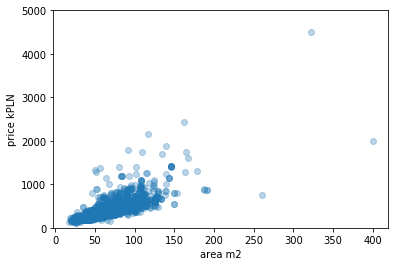

In [6]:
# house_prices = house_prices[:100]

_ = scatter(house_prices.area, house_prices.price, alpha=0.3)
_ = xlabel('area m2')
_ = ylabel('price kPLN')
ylim(0, 5000)

## Linear regression analytical solution

We will now find the linear relation between house area and price.

Our data forms a table:

In [7]:
house_prices.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


## Overview of learning

We have gathered a dataset consisting of pairs $\{(x^{(i)}, y^{(i)}), i=1\ldots N \}$. We want to find the relation between $x$, the *independent* variable, area in our example and $y$, the *dependent* variable, price in the example.

We will define a family of *hypotheses* (functions) parameterized by a vector of parameters $\Theta$. 

$$ y \approx h(x; \Theta). $$

To *learn* the relation between areas and prices, or in general between $x$ and $y$, we will search the space of hypotheses (by changing the parameters $\Theta$) to find the one whose predictions best match the true targets.

We will need a *cost function* to measure the goodness of fit between hypotheses and the data. 

Finally, we will need a training (learning) algorithm that will perform the search for us.

## The hypothesis

We will start with a simple linear family of hypotheses:
$$ h(x;\Theta) = \Theta_0 + \Theta_1 x. $$


## The cost function

We will measure the discrepancy between predictions of a hypothesis and the true $y$ on the dataset by computing the sum of squares of errors:

$$ J(\Theta) = \sum_{i=1}^{N} (y^{(i)}-h(x^{(i)};\Theta))^2 $$

## The training algorithm

We will first find the optimal $\Theta$ by deriving the analytical solution. However we will first generalize the problem a little, by assuming that $x$ can be a vector of values, $x=[x_1,\ldots,x_m]$. We will also assume, that $x_0=1$. Therefore:
    
$$ h(x;\Theta) = \Theta{}_0 + \sum_{j=1}^m \Theta_j x_j = \sum_{j=0}^m \Theta_j x_j = \Theta^T x $$

The cost function then becomes

$$ J(\Theta) = \sum_{i=1}^N (y^{(i)} - \Theta^T x^{(i)})^2 $$

We will make even greater use of matrix calculus. If each data sample $x$ is a vector, we can stack them into a large matrix $X \in \mathbb{R}^{m\times N}$, such that the $i$-th column of $X$ is the sample $x^{(i)}$ likewise we will concatenate all targets $y^{(i)}$ into a matrix $Y\in\mathbb{R}^{1 \times N}$. Armed with this notation, we can compute the predictions on all data points as $\Theta^T X$ and compute the matrix of errors $E\in \mathbb{R}^{1 \times N}$ as:

$$ E = \Theta^T X - Y. $$

Finally, please note that the cost function becomes simply:

$$ J(\Theta) = E E^T = (\Theta^T X - Y)(\Theta^T X - Y)^T $$

We will compute the *gradient* of $J$ with respect to $\Theta$. By definition, we will assume that the gradient is also a vector of the same shape as $\Theta$. To quickly compute the gradient, we will use the matrix calculus relations described here: http://www.ee.ic.ac.uk/hp/staff/dmb/matrix/calculus.html and here: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf:

$$ \frac{\partial J(\Theta)}{\partial\Theta} = \frac{\partial}{\partial\Theta} (\Theta^T X - Y)(\Theta^T X - Y)^T =
\frac{\partial}{\partial\Theta} [\Theta^T X X^T \Theta - YX^T\Theta - \Theta^T X Y^T + YY^T] = 
2 X X^T \Theta -2 X Y^T  = 2X(X^T\Theta - Y^T) = 2X E^T$$

Solving for the zero-crossing of the derivative we obtain:

$$
\begin{align}
2 X X^T \Theta &= 2 X Y^T \\
\Theta &= (X X^T) ^{-1} X Y^T 
\end{align}
$$

Please note: this is also called the Moore-Penrose pseudo-inverse of matrix $X$.

## Example of operation

In [8]:
X = np.vstack((np.ones_like(house_prices.area), house_prices.area))
X[:,:8]

array([[ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
       [66.8 , 55.03, 70.8 , 29.02, 45.76, 38.99, 55.7 , 76.42]])

In [9]:
Y = np.asarray(house_prices.price)[None,:]
Y

array([[367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]])

Remember, $\Theta = (X X^T)^{-1} X Y^T$.

In [10]:
Theta = np.linalg.inv(X.dot(X.T)).dot(X).dot(Y.T)
Theta

array([[-14.09901832],
       [  6.54132271]])

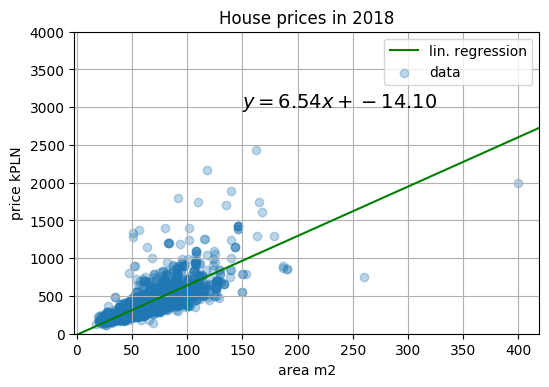

In [11]:
figure(figsize=(6,4), dpi=100)
scatter(house_prices.area, house_prices.price, alpha=0.3, label='data')

test_areas = np.linspace(xlim()[0], xlim()[1], 512)
test_prices = Theta[0] + Theta[1]*test_areas


plot(test_areas, test_prices,'g', label='lin. regression')
xlim(test_areas[0], test_areas[-1])
xlabel('area m2')
ylabel('price kPLN')
text(150, 3000, "$y=%.2fx+%.2f$" % (Theta[1], Theta[0]), fontsize=14)
legend()
ylim(0, 4000)
title('House prices in 2018')
grid(True)

## Interpretation of the least squares criterion

We will now work out a *probabilistic interpretation* of our model. We will assume that the data is generated according to the following process:
1. $x$ is sampled
2. $y$ is computed as $y=\Theta^T x + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0,\sigma)$

We assume that the dependent variable $y$ is produced by linearly transforming $x$ and adding a little bit of Gaussian noise. The intuition is that there is the main linear relation that we model, and all other phenomena add up as noise, which by the central limit theorem we assume to be normal.

We assume that for each sample in our dataset the noise was sampled independently from the same noise distribution (IID). This allows us to write the following conditional distribution of $y$ given $x$:

$$ p(y|x;\Theta) = \mathcal{N}(y; \mu=\Theta^T x, \sigma) $$

Due to the IID assumption for the noise variables $\epsilon^{(i)}$, we can also assume that the targets $y$ in our data aree conditionally independent given the $x$s. This allows us to easily compute the probability of observing the collected data under our data-generating hypothesis as:

$$
\begin{split}
p(Data; \Theta) &= \prod_{i=1}^N p(y^{(i)}|x^{(i)};\Theta) \\
&= \prod_{i=1}^N \mathcal{N}(y^{(i)}; \mu =\Theta^T x^{(i)}, \sigma) \\
&=  \prod_{i=1}^N \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y^{(i)}-\Theta^Tx^{(i)})^2}{2\sigma^2}\right)
\end{split}
$$

We will use the maximum likelihood principle to choose $\Theta$. More specifically, this time we will minimize the *negative log-likelihood*, written in short nll:

$$ 
\begin{align}
nll(\Theta) &= - \log p(Data; \Theta) \\
&= -\sum_{i=1}^{N}\log \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y^{(i)}-\Theta^Tx^{(i)})^2}{2\sigma^2}\right)  \\
&= -\sum_{i=1}^{N}\log \frac{1}{\sqrt{2\pi}\sigma} - \frac{(y^{(i)}-\Theta^Tx^{(i)})^2}{2\sigma^2} \\
&= C + \frac{1}{2\sigma^2}\sum_{i=1}^{N}(y^{(i)}-\Theta^Tx^{(i)})^2 
\end{align}
$$

Note that minimization of $nll$ leads to maximization of the likelihood. Therefore the Gaussian noise assumption leads to the least squares cost function! 

## Validity of the Gaussian noise assumption

Statisticians like to check if the residuals (the errors made by our model on the train set) follow indeed the assumed noise distribution. In the house prices example we can see that the residuals do not strictly follow the Gaussian distribution. Maybe we should take into account other house features, such as neighborhood, age, whether it is a new or used one... Think how you would incorporate such new information. Is it still possible to use linear regression to fit a model dependent on many variables?

In the following example the Gaussian noise assumption will be satisfied. We will download data of people's height vs weight.

In [0]:
url = 'http://socr.ucla.edu/docs/resources/SOCR_Data/SOCR_Data_Dinov_020108_HeightsWeights.html'
height_weight = pd.read_html(url)[0]

In [13]:
height_weight.head()

,0,1,2
0,Index,Height(Inches),Weight(Pounds)
1,1,65.78331,112.9925
2,2,71.51521,136.4873
3,3,69.39874,153.0269
4,4,68.2166,142.3354


In [0]:
inch_to_meter = 0.0254
height = np.asarray(height_weight.iloc[1:,1].astype(float))[None,:] * inch_to_meter #convert to meters
pound_to_kg = 0.453592
weight = np.asarray(height_weight.iloc[1:,2].astype(float))[None,:] * pound_to_kg # convert to kg

Text(0, 0.5, 'weight [kg]')

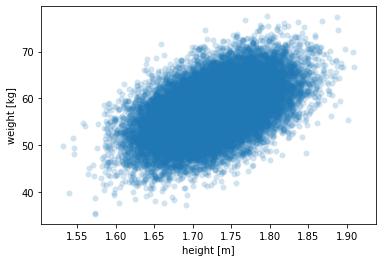

In [15]:
scatter(height, weight, alpha=0.2, linewidths=0)
xlabel('height [m]')
ylabel('weight [kg]')

In [16]:
X = np.vstack((np.ones_like(height), height))
X

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.67089607, 1.81648633, 1.762728  , ..., 1.64334317, 1.71524117,
        1.74949129]])

In [17]:
Y = weight
Y

array([[51.25249406, 61.90954738, 69.41177762, ..., 53.64428468,
        59.99579737, 56.64193813]])

In [18]:
Theta = np.linalg.inv(X.dot(X.T)).dot(X).dot(Y.T)
Theta

array([[-37.45569645],
       [ 55.06457669]])

Text(0, 0.5, 'weight [kg]')

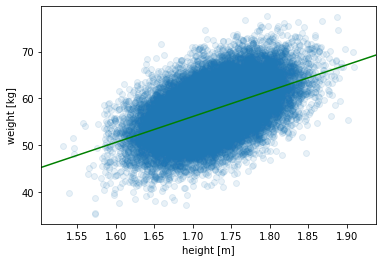

In [19]:
scatter(height, weight, alpha=0.1)
test_heights = np.linspace(xlim()[0], xlim()[1], 512)
test_weights = Theta[0] + Theta[1]*test_heights

plot(test_heights, test_weights,'g')
xlim(test_heights[0], test_heights[-1])
xlabel('height [m]')
ylabel('weight [kg]')

In [20]:
E = Theta.T.dot(X) - Y
E

array([[ 3.29899449,  0.65880721, -9.80360316, ..., -0.60998512,
        -3.00246477,  2.23736295]])

Text(0.5, 1.0, 'Scatter plot of residuals.')

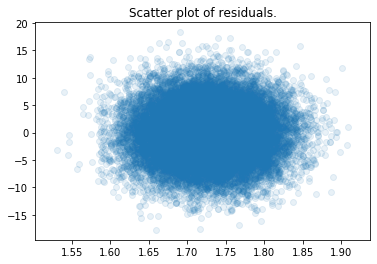

In [21]:
scatter (X[1,:], E, alpha=0.1)
title("Scatter plot of residuals.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Histogram of residuals\nNote the nice gaussian fit')

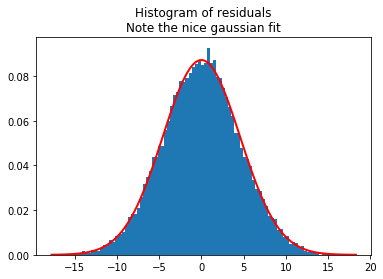

In [22]:
counts, bins, patches = hist(E.ravel(),100, normed=True)

mu = E.mean()
std = E.std()
e_range = np.linspace(bins[0], bins[-1], 100)
plot(e_range, 1/np.sqrt(2*np.pi)/std*np.exp(-e_range**2/2/std**2), 'r', linewidth=2)
title("Histogram of residuals\nNote the nice gaussian fit")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 1.0, 'Histogram of residuals for heights=1.850000 +-1cmSlice residual mean: -0.030103 stdev: 4.499539')

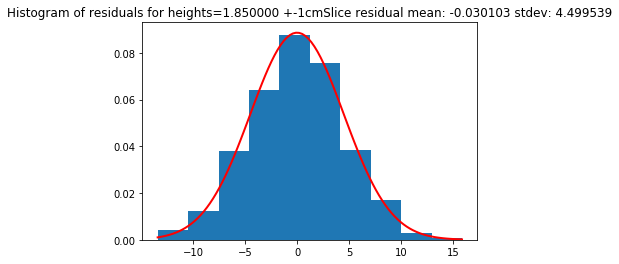

In [23]:
# Analyze the histogram of errors along a few heights

slice_height = 1.85
selected = np.abs(X[1,:]-slice_height) < 0.05

selected_E = E[0,selected]
counts, bins, patches = hist(selected_E, 10, normed=True)

selected_mu = selected_E.mean()
selected_std = selected_E.std()
selected_e_range = np.linspace(bins[0], bins[-1], 100)
plot(selected_e_range, 1/np.sqrt(2*np.pi)/selected_std*np.exp(-(selected_mu-selected_e_range)**2/2/selected_std**2), 'r', linewidth=2)

title('Histogram of residuals for heights=%f +-1cm' 
      'Slice residual mean: %f stdev: %f'% (slice_height,selected_mu, selected_std))

Text(0.5, 0, 'height')

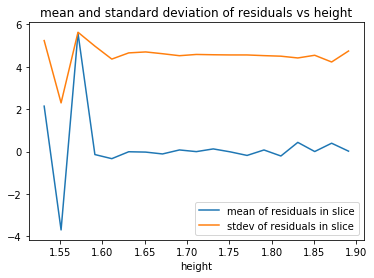

In [24]:
# Are the errors homoscedastic?

err_stats = []

slice_width = 0.02

for slice_height in np.arange(height.min(), height.max(), slice_width):
    selected = np.abs(X[1,:]-slice_height) < slice_width/2.0

    selected_E = E[0,selected]

    selected_mu = selected_E.mean()
    selected_std = selected_E.std()
    err_stats.append((slice_height, selected_mu, selected_std))
    
err_stats = np.asarray(err_stats)

plot(err_stats[:,0], err_stats[:,1], label='mean of residuals in slice')
plot(err_stats[:,0], err_stats[:,2], label='stdev of residuals in slice')
legend(loc='lower right')
title("mean and standard deviation of residuals vs height")
xlabel("height")